Our team *Recommendation Medicines : Using a review* that fit the patient's condition. The process proceeds in the order of **data exploration  - data preprocessing - model - conclusion - limit**. In the data exploration part, we will look at data types with visualization techniques and statistical techniques. Through this process, we can set the topic, preprocess the data to fit the objective, and create various variables to fit model.  At the model part, emotion analysis using word dictionary, n-gram applying deep learning, etc. were used. In order to compensate the limitation of natural language processing, Lightgbm machine learning model was used and reliability was further secured through usefulcount. Finally, I will introduce the limitations and weak points of conclusion and analysis of the project.

In [1]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import os
import string
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

## 1. Exploration Data Analysis

### 1.1. Data understanding


First we will import Train data and Test data. The sizes of the two data are as follows:

It was data from https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29 and crawled reviews from online pharmaceutical review sites.

In [2]:
import os
print(os.listdir("../input"))

['kuc-hackathon-winter-2018', 'dictionary']


In [3]:
df_train = pd.read_csv("../input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv", parse_dates=["date"])
df_test = pd.read_csv("../input/kuc-hackathon-winter-2018/drugsComTest_raw.csv", parse_dates=["date"])

In [4]:
print("Train shape :" ,df_train.shape)
print("Test shape :", df_test.shape)

Train shape : (161297, 7)
Test shape : (53766, 7)


This is the result of looking at the data through the head () command. There are six variables except for the unique ID that identifies the individual, and review is the key variable.

In [5]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


These are additional explanations for variables.

- drugName (categorical): name of drug 
- condition (categorical): name of condition
- review (text): patient review 
- rating (numerical): 10 star patient rating 
- date (date): date of review entry 
- usefulCount (numerical): number of users who found review useful

The structure of the data is that a patient with a unique ID purchases a drug that meets his condition and writes a review and rating for the drug he/she purchased on the date. Afterwards, if the others read that review and find it helpful, they will click usefulCount, which will add 1 for the variable.

### 1.2. Data understanding

First, we will start exploring variables, starting from uniqueID. We compared the unique number of unique IDs and the length of the train data to see if the same customer has written multiple reviews, and there weren't more than one reviews for one customer.

In [6]:
print("unique values count of train : " ,len(set(df_train['uniqueID'].values)))
print("length of train : " ,df_train.shape[0])

unique values count of train :  161297
length of train :  161297


DrugName is closely related to condition, so we have analyzed them together. The unique values of the two variables are 3671 and 917, respectively, and there are about 4 drugs for each condition. Let's go ahead and visualize this in more detail.

In [7]:
df_all = pd.concat([df_train,df_test])

Text(0.5,1,'Top20 : The number of drugs per condition.')

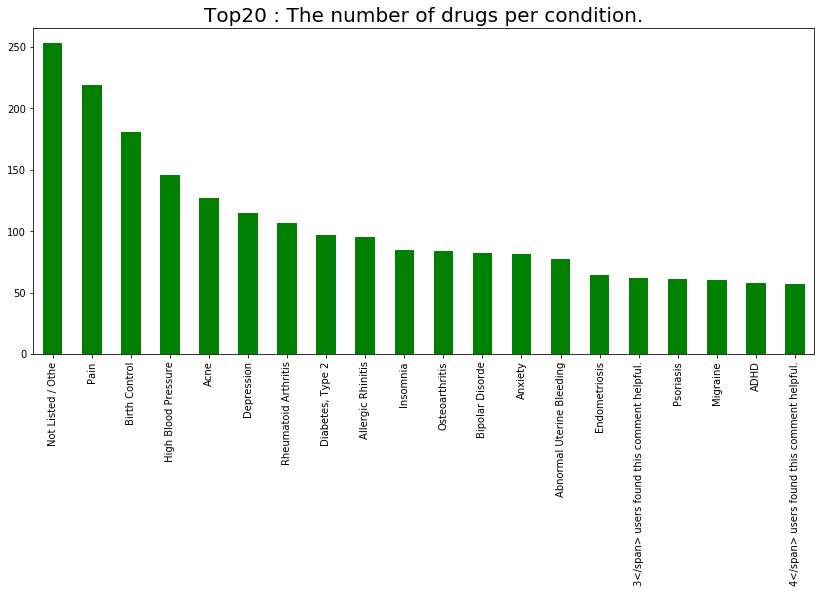

In [8]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

As you can see from the picture above, the number of drugs for top eight conditions is about 100 for each condition. On the other hand, it should be noted that the phrase "3</span> users found this comment helpful" appears in the condition, which seems like an error in the crawling process. I have looked into it to see in more details.

In [9]:
df_all[df_all['condition']=='3</span> users found this comment helpful.'].head(3)

,uniqueID,drugName,condition,review,rating,date,usefulCount
243,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,2010-06-01,3
1864,124318,Skyla,3</span> users found this comment helpful.,"""Never pregnant,28,retroverted small (6cm) ute...",1,2015-12-16,3
3322,202848,ProAir HFA,3</span> users found this comment helpful.,"""I get chest colds and asthmatic symptoms in t...",9,2015-12-12,3


It is expected that for structure of '</ span> users found this comment helpful.' phrase, there will be not only 3, but also 4 as shown above, and other numbers as well. We will remove these data in the future preprocessing.

The following are the low 20 conditions of 'drugs per condition'. As you can see, the number is all 1. Considering the recommendation system, it is not feasible to recommend with that when there is only one product. Therefore, we will analyze only the conditions that have at least 2 drugs per condition.

Text(0.5,1,'Bottom20 : The number of drugs per condition.')

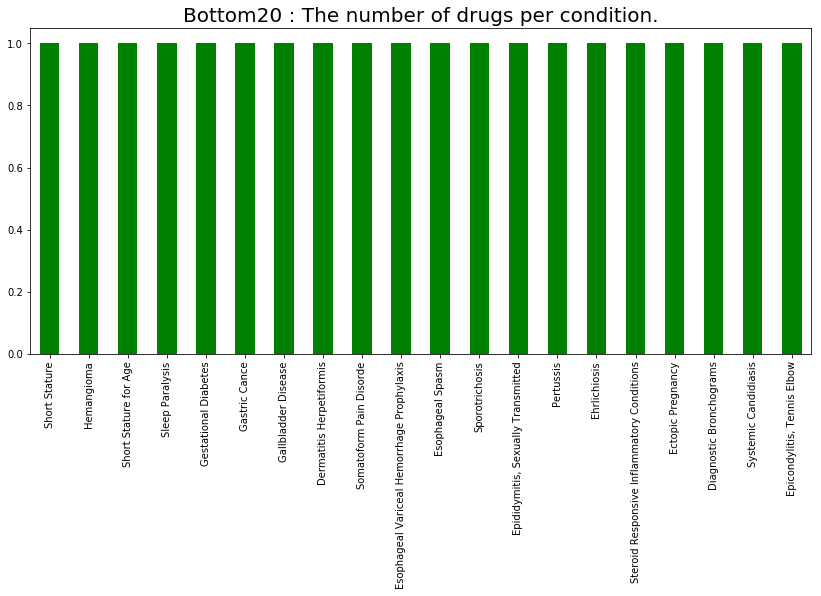

In [10]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom20 : The number of drugs per condition.", fontsize = 20)

Next, let's have a look at the review. First, noticeable parts are the html strings like \ r \ n, and the parts that express emotions in parentheses such as (very unusual for him) and (a good thing) and words in capital letters like MUCH.

In [11]:
df_train['review'][1]

'"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'

In addition, there were some words with errors like didn&# 039;t for didn't, and also characters like ...

In [12]:
df_train['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

We will delete these parts in preprocessing as well.

Next up, it's Word Cloud.

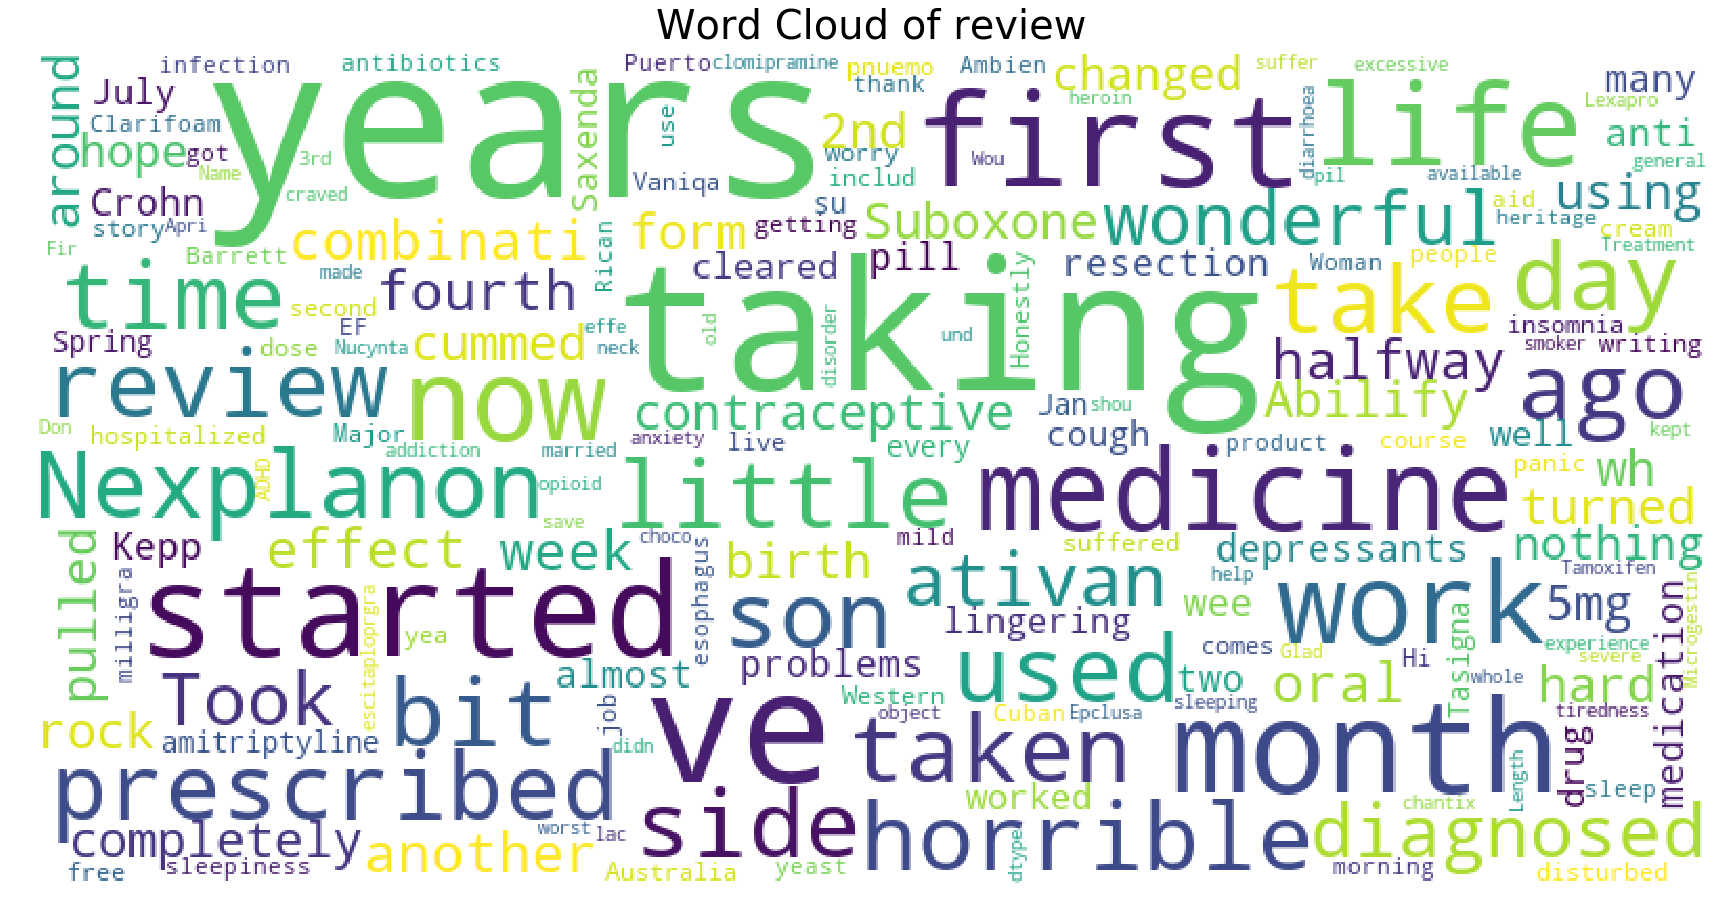

In [13]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc kernel 
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_all["review"], title="Word Cloud of review")

Next, we will classify 1 ~ 5 as negative, and 6 ~ 10 as positive, and we will check through 1 ~ 4 grams which corpus best classifies emotions.

In [14]:
from collections import defaultdict
df_all_6_10 = df_all[df_all["rating"]>5]
df_all_1_5 = df_all[df_all["rating"]<6]

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



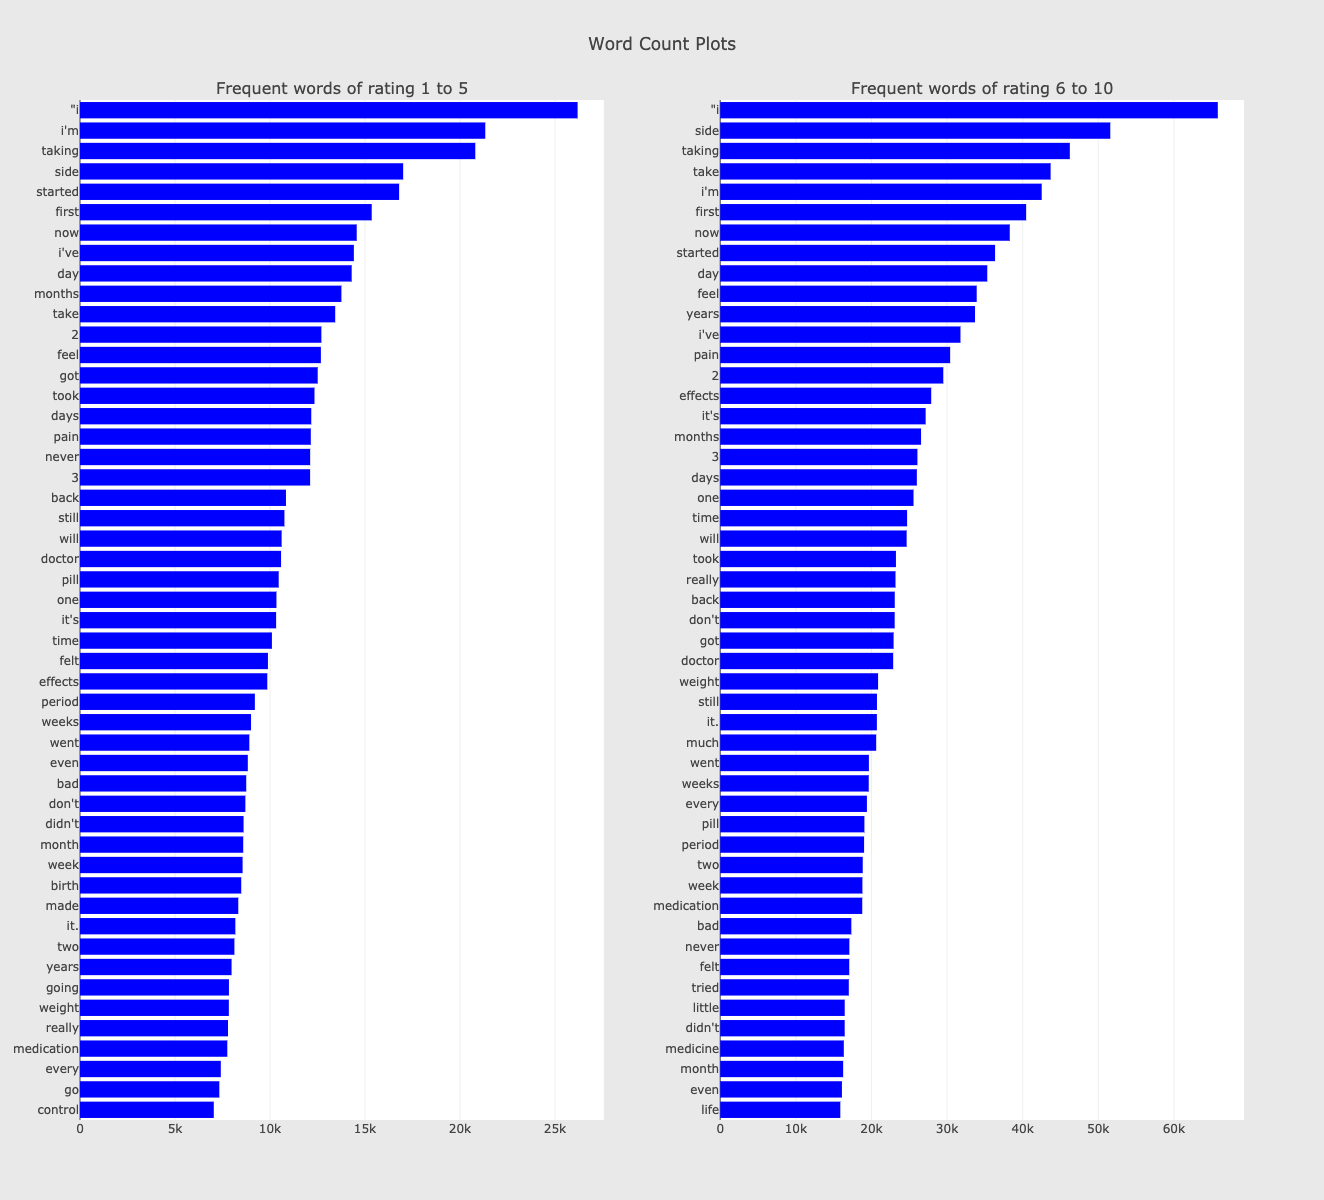

In [15]:
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from rating  8 to 10 review ##
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from rating  4 to 7 review ##
freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of rating 1 to 5", 
                                          "Frequent words of rating 6 to 10"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

When you use 1-gram, you can see that the top 5 words have the same contents, although the order of left (negative) and right (positive) are different. This means when we analyze the text with a single corpus, it does not classify the emotion well. So, we will expand the corpus.

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



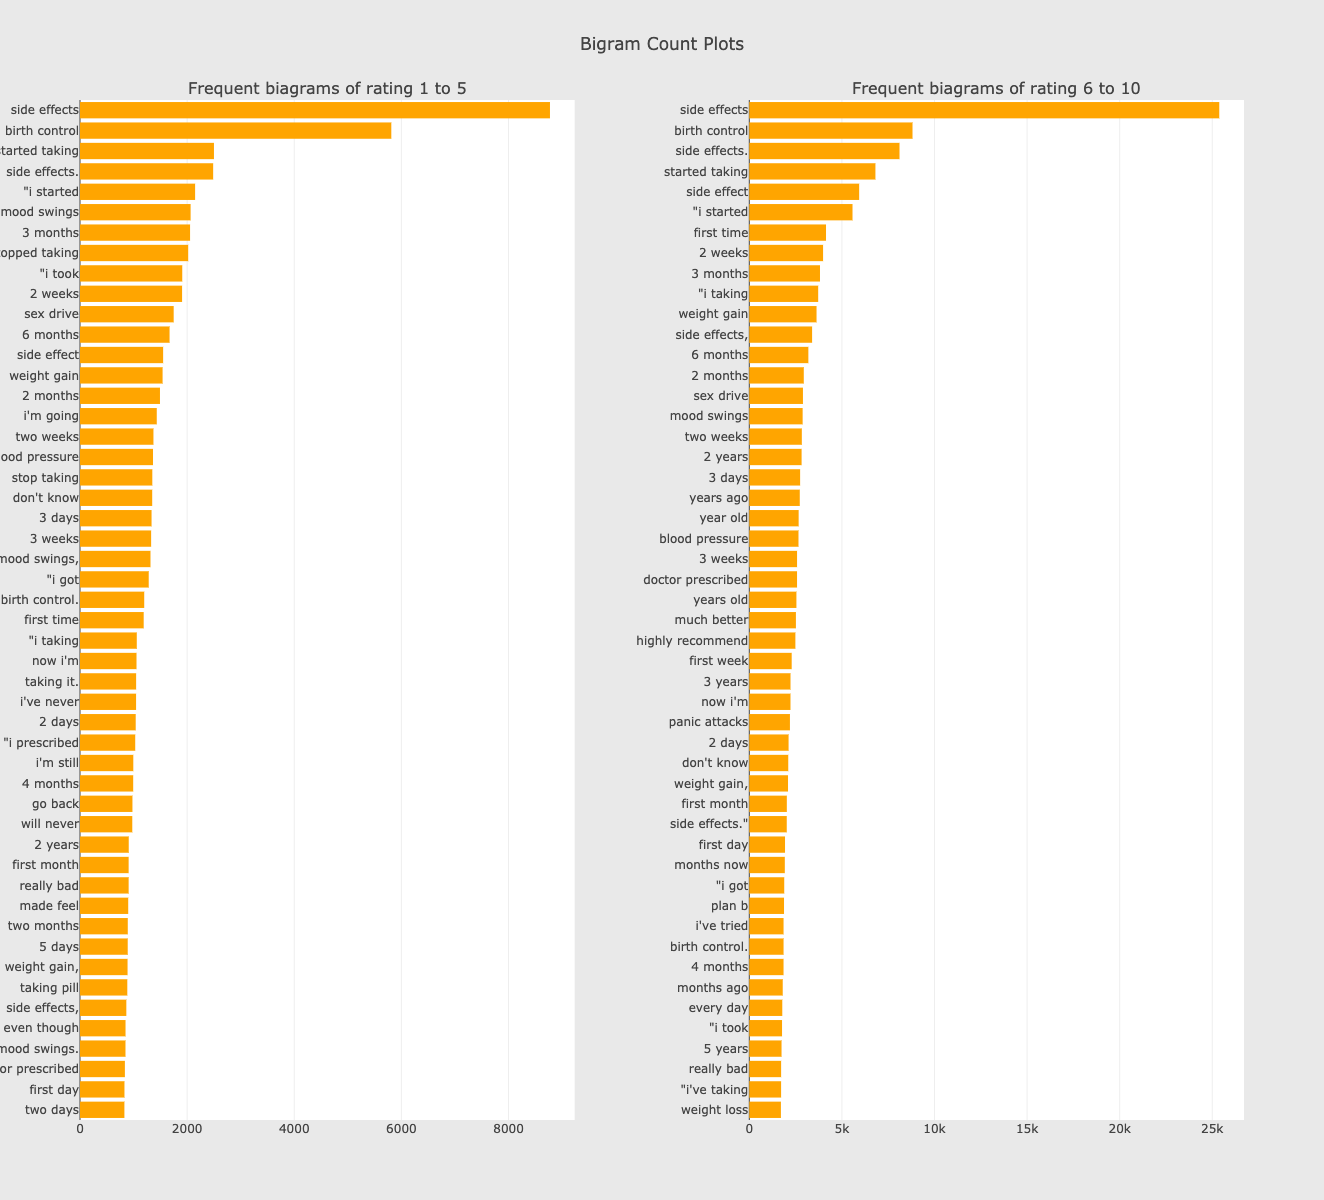

In [16]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of rating 1 to 5", 
                                          "Frequent biagrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

Likewise, in 2-gram, the contents of the top five corpus are similar, and it is hard to classify positive and negative. In addition, 'side effects' and 'side effects.' are interpreted differently, which means preprocessing of review data is necessary. However, you can see that this is better to classify emotions rather than previous 1-grams, like side effects, weight gain, and highly recommend.

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



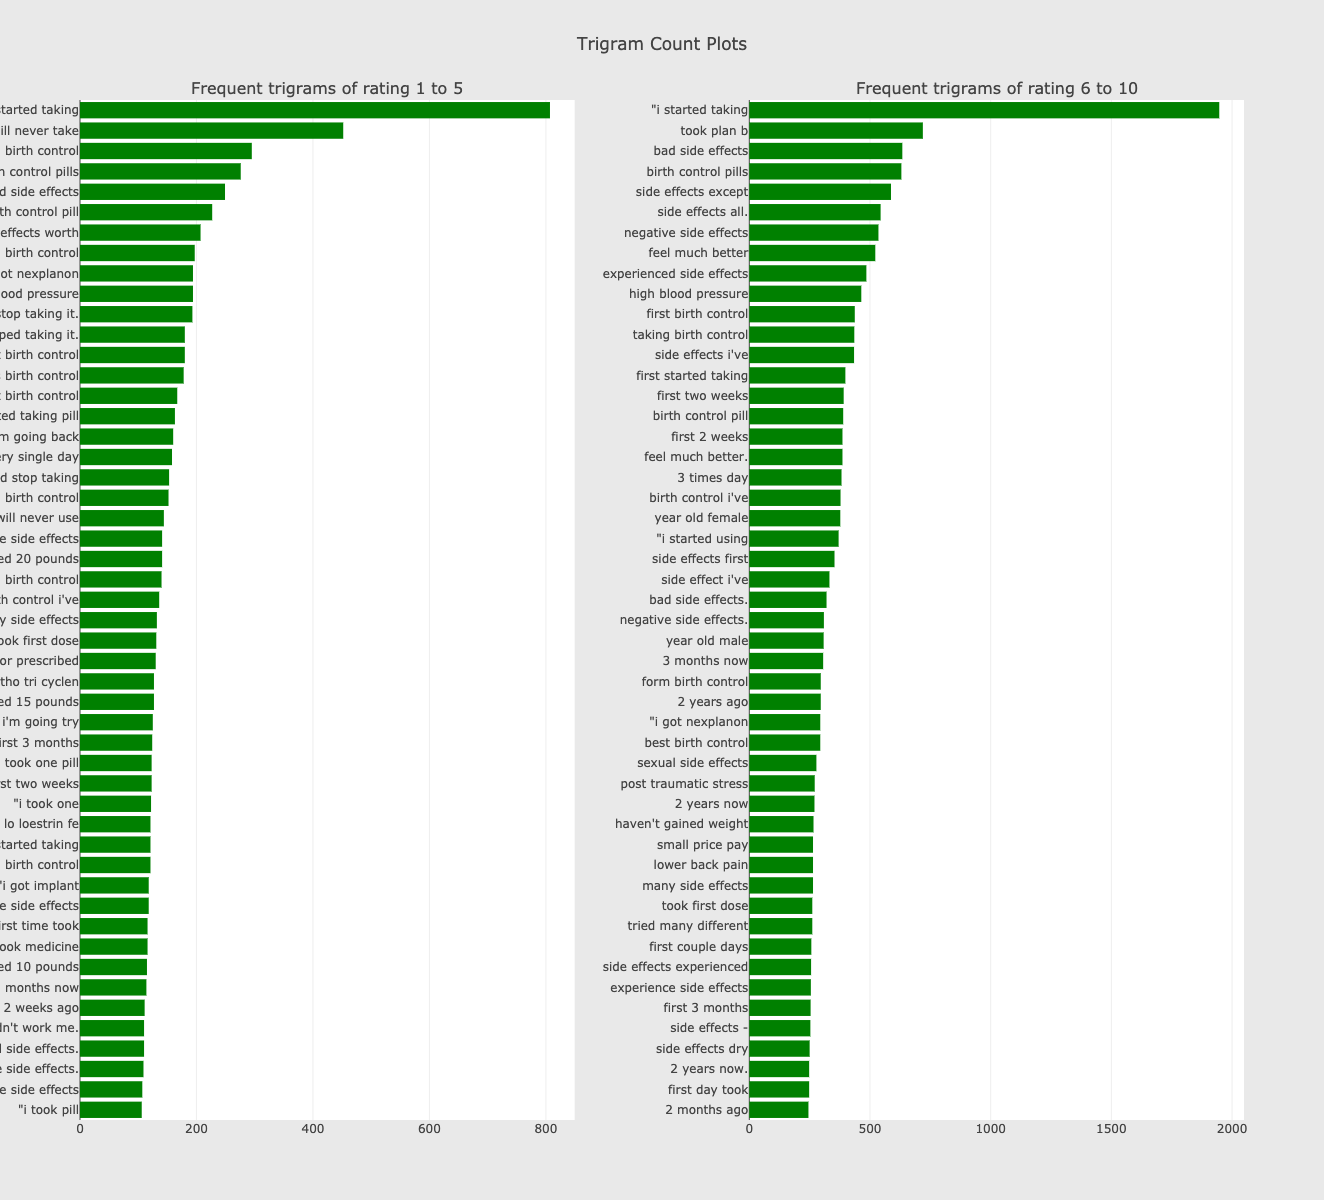

In [17]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent trigrams of rating 1 to 5", 
                                          "Frequent trigrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

From 3-gram you can see that there is a difference between positive and negative corpus. Bad side effects, birth control pills, negative side effects are corpus that classify positive and negative. However, both positive and negative parts can be thought that it has missing parts that reverses the context, such as' not' in front of a corpus.

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



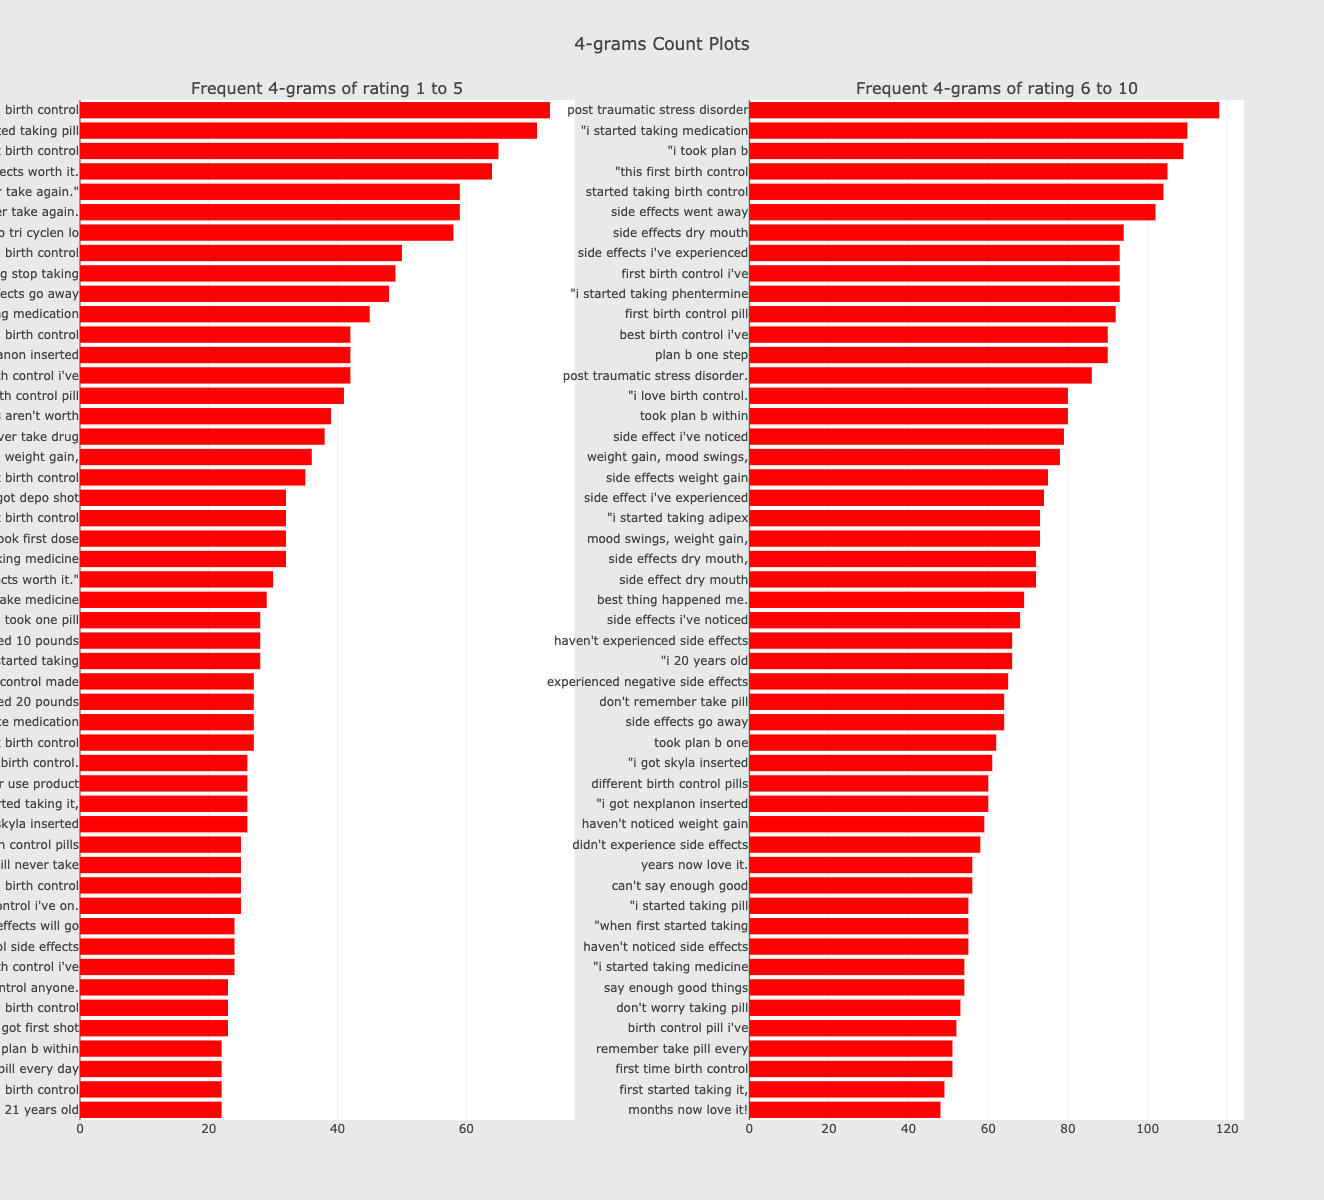

In [18]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent 4-grams of rating 1 to 5", 
                                          "Frequent 4-grams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="4-grams Count Plots")
py.iplot(fig, filename='word-plots')

Clearly, 4-gram classifies emotions much betther than other grams. Therefore, we will use 4-gram to build deep learning model.

Next, we will look for relationship between rating and weather. First of all, we will count the number of ratings.

Text(0.5,1,'Count of rating values')

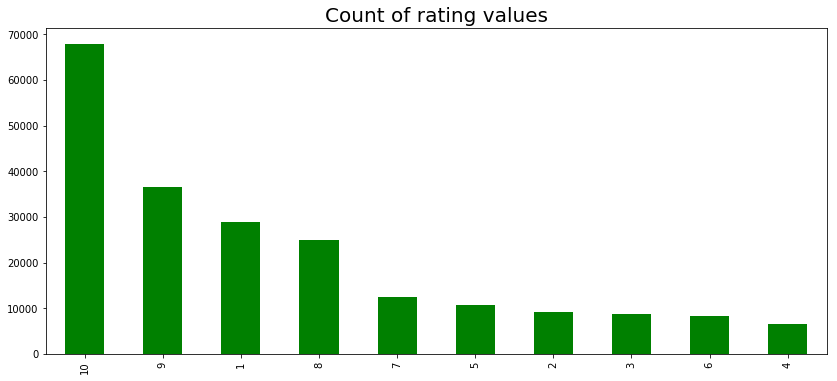

In [19]:
rating = df_all['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of rating values", fontsize = 20)

Most people choose four values; 10, 9, 1, 8, and the number of 10 is more than twice as many as the others. With this, we can see that the percentage of positives is higher than negative, and people's reactions are extreme.

Next, we will check the number of reviews and percentage of ratings according to weather.

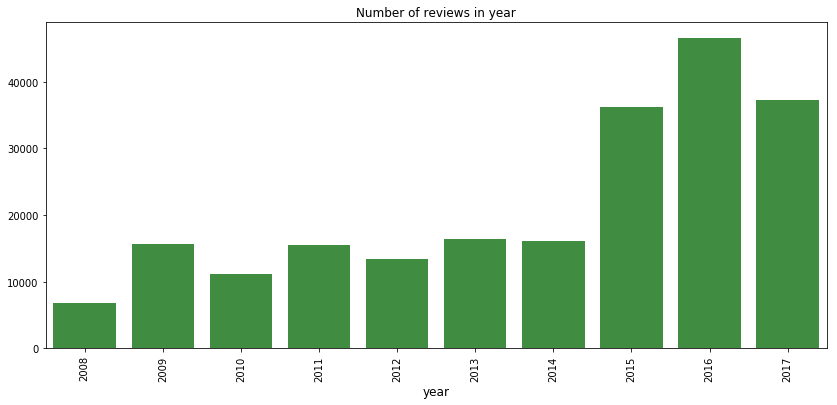

In [20]:
# Code in https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
# SRK - Simple Exploration Notebook 

cnt_srs = df_all['date'].dt.year.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in year")
plt.show()

Text(0.5,1,'Mean rating in year')

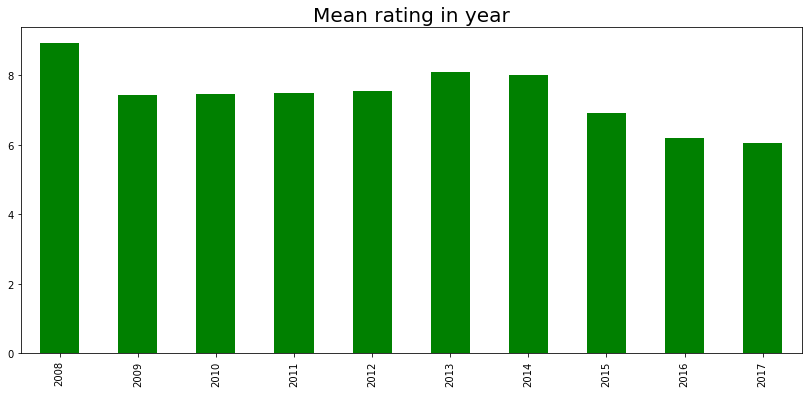

In [21]:
df_all['year'] = df_all['date'].dt.year
rating = df_all.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in year", fontsize = 20)

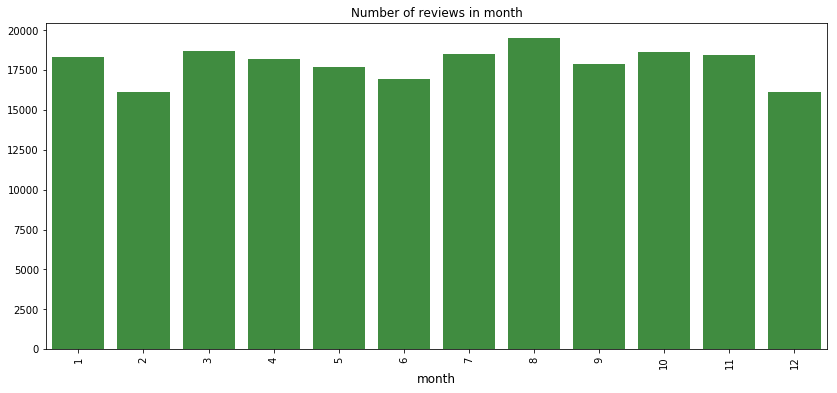

In [22]:
# Code in https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
# SRK - Simple Exploration Notebook 

cnt_srs = df_all['date'].dt.month.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('month', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in month")
plt.show()

Text(0.5,1,'Mean rating in month')

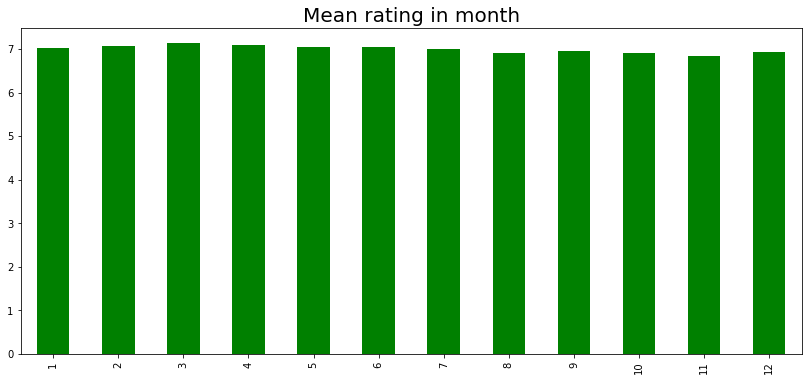

In [23]:
df_all['month'] = df_all['date'].dt.month
rating = df_all.groupby('month')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in month", fontsize = 20)

Interestingly, you can see that the average rating differs by year, but it is similar by month.

Text(0.5,1,'Mean rating in day')

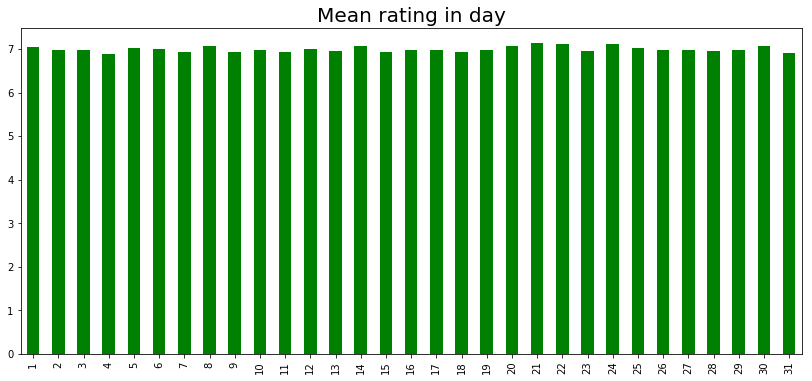

In [24]:
df_all['day'] = df_all['date'].dt.day
rating = df_all.groupby('day')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in day", fontsize = 20)

We checked whether the day of the week affects the rating like salary day, but it does not make a big difference.

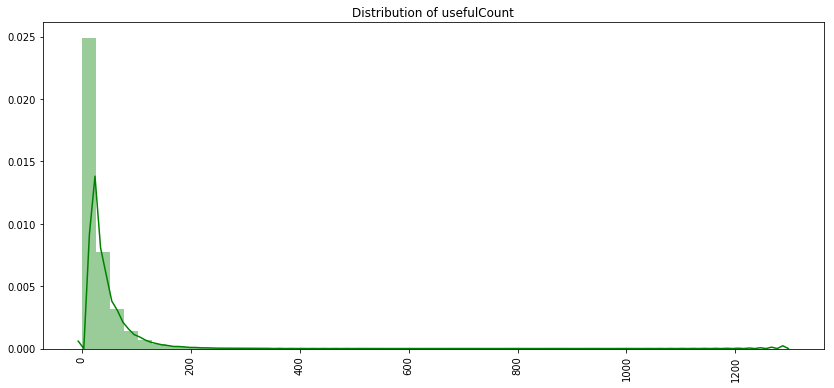

In [25]:
plt.figure(figsize=(14,6))
sns.distplot(df_all["usefulCount"].dropna(),color="green")
plt.xticks(rotation='vertical')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Distribution of usefulCount")
plt.show()

In [26]:
df_all["usefulCount"].describe()

count    215063.000000
mean         28.001004
std          36.346069
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

If you look at the distribution of usefulCount, you can see that the difference between minimum and maximum is 1291, which is high. In addition, the deviation is huge, which is 36. The reason for this is that the more drugs people look for, the more people read the review no matter their contents are good or bad, which makes the usefulcount very high. So when we create the model, we will normalize it by conditions, considering people's accessibility.

### 1.3 Missing value

Text(0.5,1,'Total Missing Value ')

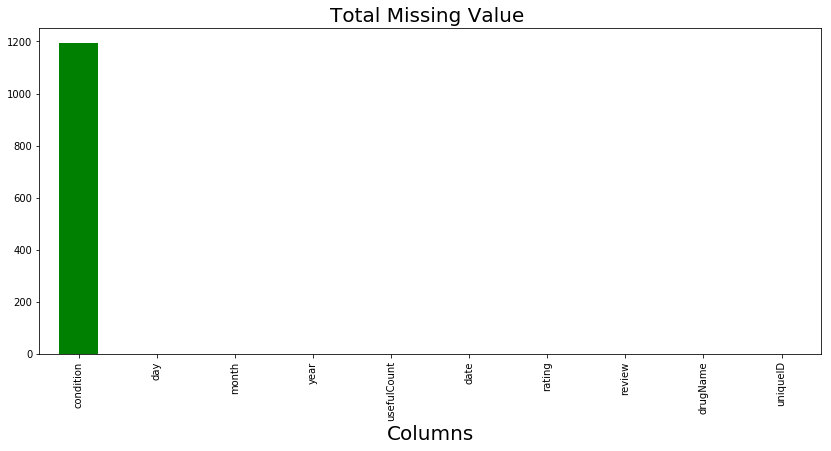

In [27]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [28]:
print("Missing value (%):", 1200/df_all.shape[0] *100)

Missing value (%): 0.5579760349292998


We will delete because the percentage is lower than 1%.

## 2. Date Preprocessing

### 2.1. Missing Values Removal

In [29]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

Text(0.5,1,'Total Missing Value ')

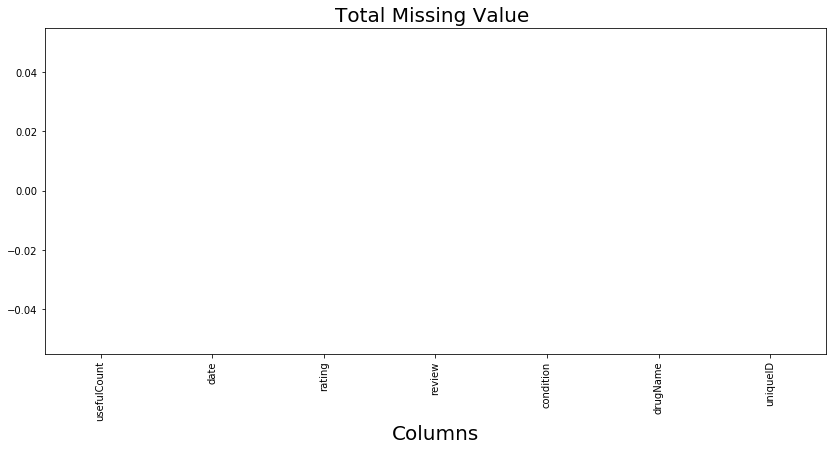

In [30]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

### 2.2 Condition Preprocessing

We will delete the sentences with the form above.

In [31]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)

In [32]:
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

Next, we will delete conditions with only one drug.

In [33]:
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
816,Hemangioma,1
817,Q Feve,1
818,Urinary Retention,1
819,Diagnostic Bronchograms,1
820,Steroid Responsive Inflammatory Conditions,1
821,Cluster-Tic Syndrome,1
822,Nausea (phosphorated carbohydrate solution),1
823,Ramsay Hunt Syndrome,1
824,Rat-bite Feve,1
825,Hemorrhoids (pramoxine / zinc oxide),1


In [34]:
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]

0                           Uveitis, Posteri
1                    Pseudogout, Prophylaxis
2                        Infectious Diarrhea
3                   Thyroid Suppression Test
4                                 Angioedema
5                                Scleroderma
6                                        mis
7            Anti NMDA Receptor Encephalitis
8                                     mist (
9    Pruritus of Partial Biliary Obstruction
Name: condition, dtype: object

In [35]:
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

### 2.3 Review Preprocessing

In [36]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

- \r\n : we need to convert html grammer
- ... , &#039; : deal with not alphabet

In [37]:
stops = set(stopwords.words('english'))
#stops

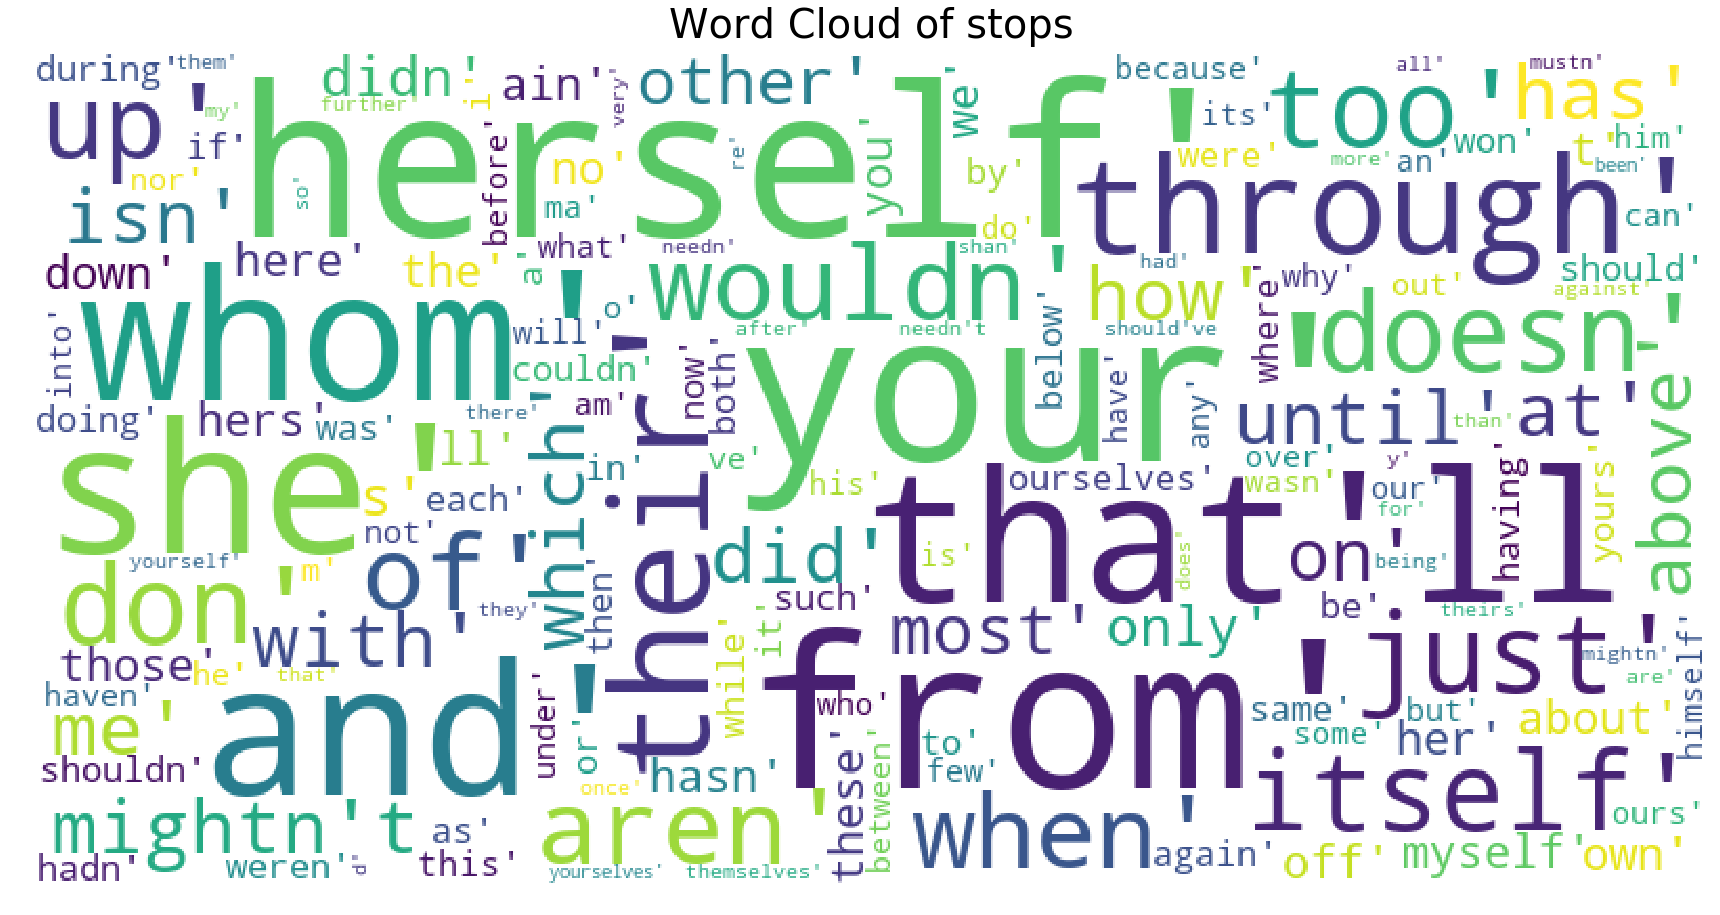

In [38]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc kernel 
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(stops, title="Word Cloud of stops")

First, let's see what words are used as stopwords. There are many words that include not, like needn't. These words are key parts of emotional analysis, so we will remove them from stopwords.

In [39]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [40]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [41]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [42]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)

CPU times: user 3min 12s, sys: 565 ms, total: 3min 12s
Wall time: 3min 14s


## 3. Model

### 3.1. Deep Learning Model Using N-gram

In [43]:
# Make a rating
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)

In [44]:
df_train, df_test = train_test_split(df_all, test_size=0.33, random_state=42) 

In [45]:
# https://github.com/corazzon/KaggleStruggle/blob/master/word2vec-nlp-tutorial/tutorial-part-1.ipynb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2,
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=2,
        ngram_range=(4, 4), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [46]:
#https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [47]:
%time train_data_features = pipeline.fit_transform(df_train['review_clean'])
%time test_data_features = pipeline.fit_transform(df_test['review_clean'])

CPU times: user 34.5 s, sys: 918 ms, total: 35.4 s
Wall time: 35.4 s
CPU times: user 18.5 s, sys: 373 ms, total: 18.8 s
Wall time: 19.1 s


In [48]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [49]:
#Source code in keras Taeyoung Kim'blog
# 0. Package
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import random

# 1. Dataset
y_train = df_train['sentiment']
y_test = df_test['sentiment']
solution = y_test.copy()

# 2. Model Structure
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_shape=(20000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 3. Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               4000200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               60300     
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
activation_2 (Activation)    (None, 300)               0         
__________

Epoch 1/10
142075/142075 [==============================] - 38s 265us/step - loss: 0.5811 - acc: 0.7144
Epoch 2/10
142075/142075 [==============================] - 33s 234us/step - loss: 0.4995 - acc: 0.7590
Epoch 3/10
142075/142075 [==============================] - 33s 233us/step - loss: 0.4623 - acc: 0.7756
Epoch 4/10
142075/142075 [==============================] - 34s 238us/step - loss: 0.4420 - acc: 0.7851
Epoch 5/10
142075/142075 [==============================] - 33s 236us/step - loss: 0.4292 - acc: 0.7899
Epoch 6/10
142075/142075 [==============================] - 34s 237us/step - loss: 0.4195 - acc: 0.7944
Epoch 7/10
142075/142075 [==============================] - 34s 238us/step - loss: 0.4120 - acc: 0.7975
Epoch 8/10
142075/142075 [==============================] - 33s 232us/step - loss: 0.4059 - acc: 0.8000
Epoch 9/10
142075/142075 [==============================] - 33s 234us/step - loss: 0.4010 - acc: 0.8019
Epoch 10/10
142075/142075 [==============================] - 34s

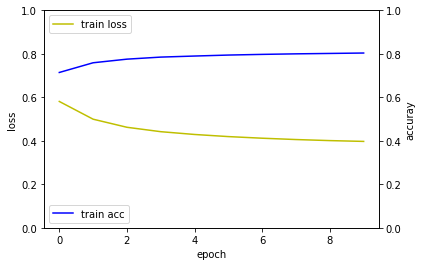

69978/69978 [==============================] - 11s 159us/step
loss_and_metrics : [1.0595309024519584, 0.6479036268626718]


In [51]:
# 4. Train model
hist = model.fit(train_data_features, y_train, epochs=10, batch_size=64)

# 5. Traing process
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. Evaluation
loss_and_metrics = model.evaluate(test_data_features, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

In [52]:
sub_preds_deep = model.predict(test_data_features,batch_size=32)

### 3.2 Lightgbm

To improve the low accuracy, we will use machine learning. First of all, this is the sentiment analysis model using only usefulCount.

In [53]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['sentiment']
feats = ['usefulCount']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.570406	valid_1's binary_logloss: 0.572234
[200]	training's binary_logloss: 0.570206	valid_1's binary_logloss: 0.572221
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.570241	valid_1's binary_logloss: 0.572209


In [54]:
solution = df_test['sentiment']
confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[    0, 21009],
       [    0, 48969]])

We will add variables for higher accuracy.

In [55]:
len_train = df_train.shape[0]
df_all = pd.concat([df_train,df_test])
del df_train, df_test;
gc.collect()

3430

In [56]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['day'] = df_all['date'].dt.day
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month

In [57]:
from textblob import TextBlob
from tqdm import tqdm
reviews = df_all['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment"] = Predict_Sentiment
df_all.head()

100%|██████████| 212053/212053 [02:42<00:00, 1305.11it/s]


,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment
130185,66913,Seroquel,Generalized Anxiety Disorde,"""After trying nearly every SSRI on the market ...",9,2010-11-26,102,tri near everi ssri market place pristiq impro...,1,26,2010,11,0.023958
155501,222222,Fluconazole,"Onychomycosis, Toenail","""This takes 6+ months, but did clear up a deca...",9,2008-05-03,39,take month clear decad long infect,1,3,2008,5,0.025000
75325,75807,Temazepam,Insomnia,"""Worked for awhile pretty well but then went b...",2,2016-04-21,15,work awhil pretti well went back mayb get hour...,0,21,2016,4,-0.125000
19174,229747,Ketamine,Pain,"""I was given this after surgery for pain as I ...",1,2016-04-16,19,given surgeri pain morphin tri drug sort omg w...,0,16,2016,4,0.166667
209735,102495,Aripiprazole,Major Depressive Disorde,"""Abilify served me well over a two month perio...",9,2016-12-16,5,abilifi serv well two month period antidepress...,1,16,2016,12,0.038889


In [58]:
np.corrcoef(df_all["Predict_Sentiment"], df_all["rating"])

array([[1.        , 0.25709864],
       [0.25709864, 1.        ]])

In [59]:
np.corrcoef(df_all["Predict_Sentiment"], df_all["sentiment"])

array([[1.        , 0.23518272],
       [0.23518272, 1.        ]])

In [60]:
reviews = df_all['review']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment2"] = Predict_Sentiment

100%|██████████| 212053/212053 [04:24<00:00, 802.29it/s]


In [61]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["rating"])

array([[1.        , 0.34831213],
       [0.34831213, 1.        ]])

In [62]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["sentiment"])

array([[1.        , 0.31714515],
       [0.31714515, 1.        ]])

In [63]:
#문장길이 (줄바꿈표시가 몇번나왔는지 셈)
df_all['count_sent']=df_all["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:(단어갯수)
df_all['count_word']=df_all["review_clean"].apply(lambda x: len(str(x).split()))

#Unique word count(unique한 단어 갯수)
df_all['count_unique_word']=df_all["review_clean"].apply(lambda x: len(set(str(x).split())))

#Letter count(리뷰길이)
df_all['count_letters']=df_all["review_clean"].apply(lambda x: len(str(x)))

#punctuation count(특수문자)
df_all["count_punctuations"] = df_all["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count(전부다 대문자인 단어 갯수)
df_all["count_words_upper"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count(첫글자가 대문자인 단어 갯수)
df_all["count_words_title"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords(불용어 갯수)
df_all["count_stopwords"] = df_all["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

#Average length of the words(평균단어길이)
df_all["mean_word_len"] = df_all["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

We added a season variable.

In [64]:
df_all['season'] = df_all["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

We normalized useful count.

In [65]:
df_train = df_all[:len_train]
df_test = df_all[len_train:]

In [66]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['sentiment']
feats = ['usefulCount','day','year','month','Predict_Sentiment','Predict_Sentiment2', 'count_sent',
 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations',
 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'season']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.481279	valid_1's binary_logloss: 0.494978
[200]	training's binary_logloss: 0.464017	valid_1's binary_logloss: 0.489836
[300]	training's binary_logloss: 0.448687	valid_1's binary_logloss: 0.485795
[400]	training's binary_logloss: 0.434477	valid_1's binary_logloss: 0.481708
[500]	training's binary_logloss: 0.422172	valid_1's binary_logloss: 0.478113
[600]	training's binary_logloss: 0.410153	valid_1's binary_logloss: 0.4747
[700]	training's binary_logloss: 0.399379	valid_1's binary_logloss: 0.471887
[800]	training's binary_logloss: 0.388203	valid_1's binary_logloss: 0.468779
[900]	training's binary_logloss: 0.377657	valid_1's binary_logloss: 0.465732
[1000]	training's binary_logloss: 0.367101	valid_1's binary_logloss: 0.462981
[1100]	training's binary_logloss: 0.357608	valid_1's binary_logloss: 0.460332
[1200]	training's binary_logloss: 0.348188	valid_1's binary_logloss: 0.457833
[1300]	train

In [67]:
confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[13698,  7311],
       [ 3664, 45305]])

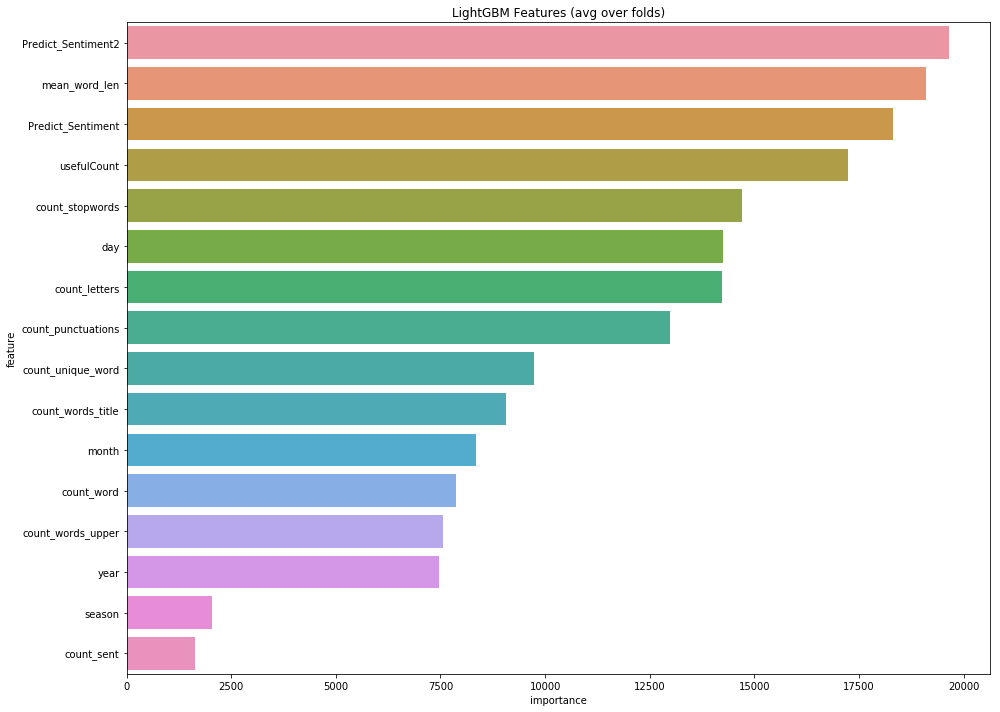

In [68]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

### 3.3 Dictionary_Sentiment_Analysis

Because the package used for prediction of 'Predict value' is formed with movie review data, it can be unsuitable for this project which analyzes reviews for drugs. To make up for this, we conducted additional emotional analysis using the Harvard emotional dictionary.

In [69]:
# import dictionary data
word_table = pd.read_csv("../input/dictionary/inquirerbasic.csv")

In [70]:
word_table.head()

,Entry,Source,Positiv,Negativ
0,A,H4Lvd,NaN,NaN
1,ABANDON,H4Lvd,NaN,Negativ
2,ABANDONMENT,H4,NaN,Negativ
3,ABATE,H4Lvd,NaN,Negativ
4,ABATEMENT,Lvd,NaN,NaN


In [71]:
##1. make list of sentiment
#Positiv word list   
temp_Positiv = []
Positiv_word_list = []
for i in range(0,len(word_table.Positiv)):
    if word_table.iloc[i,2] == "Positiv":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Positiv.append(temp2)

Positiv_word_list = list(set(temp_Positiv))
len(temp_Positiv)
len(Positiv_word_list)  #del temp_Positiv

#Negativ word list          
temp_Negativ = []
Negativ_word_list = []
for i in range(0,len(word_table.Negativ)):
    if word_table.iloc[i,3] == "Negativ":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Negativ.append(temp2)

Negativ_word_list = list(set(temp_Negativ))
len(temp_Negativ)
len(Negativ_word_list)  #del temp_Negativ

2006

We counted the number of words in review_clean which are included in dictionary.

In [72]:
##2. counting the word 98590
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary = Positiv_word_list)
content = df_test['review_clean']
X = vectorizer.fit_transform(content)
f = X.toarray()
f = pd.DataFrame(f)
f.columns=Positiv_word_list
df_test["num_Positiv_word"] = f.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = Negativ_word_list)
content = df_test['review_clean']
X2 = vectorizer2.fit_transform(content)
f2 = X2.toarray()
f2 = pd.DataFrame(f2)
f2.columns=Negativ_word_list
df_test["num_Negativ_word"] = f2.sum(axis=1)

In [73]:
##3. decide sentiment
df_test["Positiv_ratio"] = df_test["num_Positiv_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"])
df_test["sentiment_by_dic"] = df_test["Positiv_ratio"].apply(lambda x: 1 if (x>=0.5) else (0 if (x<0.5) else 0.5))

df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment,Predict_Sentiment2,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,season,num_Positiv_word,num_Negativ_word,Positiv_ratio,sentiment_by_dic
147354,126702,Brimonidine,Rosacea,"""Never , never , never use this cream !!!!!! I...",1,2015-08-31,17,never never never use cream help way angri dis...,0,31,2015,8,0.116667,-0.157955,1,58,41,335,58,5,11,54,4.793103,2,NaN,NaN,NaN,0.5
195249,84765,Ethinyl estradiol / norgestimate,Birth Control,"""I was switched to this after about 9 months o...",10,2016-05-01,3,switch month mononessa ask switch happen anywa...,1,1,2016,5,-0.257407,-0.210916,1,50,42,314,27,6,14,50,5.300000,1,NaN,NaN,NaN,0.5
86265,71559,Vraylar,Bipolar Disorde,"""I began at 1.5 then titrated to 3mg dosage. A...",3,2016-08-17,17,began titrat mg dosag first love medicin compl...,0,17,2016,8,0.041667,0.139815,1,41,38,251,20,6,9,41,5.146341,2,NaN,NaN,NaN,0.5
44172,132320,Ativan,Anxiety,"""Ativan 0.5mg calms me down considerably withi...",5,2012-01-12,26,ativan mg calm consider within minut side effe...,0,12,2012,1,-0.170530,-0.061481,1,62,54,353,27,7,8,55,4.709677,4,0.0,4.0,0.0,0.0
90569,177278,Duloxetine,Generalized Anxiety Disorde,"""My thoughts on Cymbalta: Cymbalta has left me...",1,2017-05-03,29,thought cymbalta cymbalta left fog no feel non...,0,3,2017,5,0.071429,-0.122253,2,68,61,395,38,12,19,65,4.823529,1,NaN,NaN,NaN,0.5


We defined Positiv_ratio = the number of positive words / (the number of positive words+the number of negative words) If the ratio is lower than 0.5, we classified as negative and if it's higher than 0.5, we classified as positive. With remainders, we classified as neutral, which includes the sentence without either positive or negative words.

As mentioned earlier, we have normalized usefulCount by condition to solve the problem that usefulCount shows bias depending on condition. You can then add three predicted emotion values and multiply them by the normalized usefulCount to get the predicted value.

Now, we can recommend drug by condition in order of final predicted value.

In [74]:
def userful_count(data):
    grouped = data.groupby(['condition']).size().reset_index(name='user_size')
    data = pd.merge(data,grouped,on='condition',how='left')
    return data
#___________________________________________________________
df_test =  userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

In [75]:
df_test['deep_pred'] = sub_preds_deep
df_test['machine_pred'] = sub_preds

df_test['total_pred'] = (df_test['deep_pred'] + df_test['machine_pred'] + df_test['sentiment_by_dic'])*df_test['usefulCount']

In [76]:
df_test = df_test.groupby(['condition','drugName']).agg({'total_pred' : ['mean']})
df_test

total_pred
                                                               mean
condition                drugName                                  
ADHD                     Adderall                          0.070994
                         Adderall XR                       0.042632
                         Adzenys XR-ODT                    0.010433
                         Amantadine                        0.011101
                         Amphetamine                       0.013978
                         Amphetamine / dextroamphetamine   0.047189
                         Aptensio XR                       0.005887
                         Armodafinil                       0.027927
                         Atomoxetine                       0.048048
                         Bupropion                         0.085128
                         Catapres                          0.044537
                         Clonidine                         0.059703
                         Concerta                          0.059548
                         Cylert                            0.014716
                         Daytrana                          0.031744
                         Desoxyn                           0.128838
                         Desvenlafaxine                    0.006101
                         Dexedrine                         0.063070
                         Dexmethylphenidate                0.041492
                         Dextroamphetamine                 0.051289
                         Dextrostat                        0.045621
                         Dyanavel XR                       0.016460
                         Evekeo                            0.007931
                         Focalin                           0.046825
                         Focalin XR                        0.044553
                         Guanfacine                        0.070528
                         Intuniv                           0.077367
                         Kapvay                            0.130581
                         Lisdexamfetamine                  0.045474
                         Metadate CD                       0.037865
...                                                             ...
ibromyalgia              Nuvigil                           0.203604
                         Prednisone                        0.083041
                         Pregabalin                        0.131144
                         Pristiq                           0.079809
                         Prozac                            0.187033
                         Savella                           0.114356
                         Skelaxin                          0.085034
                         Sodium oxybate                    0.107341
                         Sterapred DS                      0.057196
                         Topamax                           0.041011
                         Topiramate                        0.058816
                         Tramadol                          0.110156
                         Trazodone                         0.054970
                         Ultram                            0.083396
                         Ultram ER                         0.087207
                         Venlafaxine                       0.069520
                         Xyrem                             0.247569
lic Acid Deficiency      Deplin                            9.623953
                         L-methylfolate                    6.066286
m Pain Disorde           Milnacipran                       0.000000
min)                     Alogliptin / metformin            0.230506
                         Dapagliflozin / metformin         0.210177
                         Empagliflozin / metformin         1.273015
                         Linagliptin / metformin           0.929655
                         Metformin                         9.043337
moterol)                 Arformoterol        

## 4. Result

Our team set the topic as recommending the right medicine for the patient's condition with reviews and proceeded the project according to the topic with the data exploration, data preprocessing and modeling. In the data exploration section, we looked at the forms of data using visualization techniques and statistical techniques. We also looked for n-grams that can best represent emotions, and the relationship with date and rating. The next step was to preprocess the data according to the topic we set, such as removing the condition that has only one drug for recommendation. In the process of modeling, we used deep learning model with n-gram, and additionally used a machine learning model called Lightgbm to overcome the limitation of natural language processing. In addition, we conducted emotional analysis using emotional word dictionary to overcome limitations of package formed with movie data. In addition, we nomalized usefulcount by condition for better reliability. These steps allowed us to calculate the final predicted value and recommend the appropriate drug for each condition according to the order of the value.

## 5. Limitations

In conclusion, these are the limitations we had during the project.

1. Sentiment analysis using sentiment word dictionary has low reliability when the number of positive and negative words is small. For example, if there are 0 positive words and 1 negative word, it is classified as negative. Therefore, if the number of sentiment words is 5 or less, we could exclude the observations.
2. To ensure the reliability of the predicted values, we normalized usefulCount and multiplied it to the predicted values. However, usefulCount may tend to be higher for older reviews as the number of cumulated site visitors increases. Therefore, we should have also considered time when normalizing usefulCount.
3. If the emotion is positive, the reliability should be increased to the positive side, and if it is negative, the reliability should be increased toward the negative side. However, we simply multiplied the usefulCount for reliability and did not consider this part. So we should have multiplied considering the sign of usefulCount according to different kinds of emotion.


